In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import pickle
import math
import sys
sys.path.append('../gym-flight/')
import gym_flight
from gym_flight.utils.geo import destination
from util import *
import multiprocessing as mp
splits = mp.cpu_count() - 1
import matplotlib.pyplot as plt
from full3d_util import get_range_df, bind, unlist
from aircraft_center_3d_util import train_test_split, fix_XY

In [2]:
half_x_length = 5
half_y_length = 7
half_z_length = 12
n_mins = 5

# Preprocessing flight data

In [3]:
if os.path.isfile("processed_flight_data_" + str(n_mins) + "mins.bin"):
    flight_data = pickle.load(open("processed_flight_data_" + str(n_mins) + "mins.bin", "rb"))
else:
    if os.path.isfile("raw_flight_data_" + str(n_mins) + "mins.bin"):
        flight_data = pickle.load(open("raw_flight_data_" + str(n_mins) + "mins.bin", "rb"))
    else:
        flight_data_path = "../../samples_with_jfk_landing_flag.csv"
        dtype_dict = {"id": str, "ts": np.int64, "lat": np.float32, "lon": np.float32, "altitude": np.float32, "speed": np.float32, "jfk_landing_flag": bool}
        flight_data = pd.read_csv(flight_data_path, dtype = dtype_dict)
        flight_data = flight_data.sort_values(by = ['id', 'ts']).reset_index(drop = True)

        # Creating 5 min intervals
        temp_ts = flight_data['ts']
        temp_ts = temp_ts - temp_ts.apply(lambda x: x % (n_mins * 60))
        flight_data['round_min_ts'] = pd.to_datetime(temp_ts, unit = 's')
        flight_data['raw_ts'] = pd.to_datetime(flight_data['ts'], unit = 's')
        flight_data['prev_ts'] = flight_data[['id', 'raw_ts']].set_index(['id']).groupby(level="id").shift(1).reset_index(drop = True)
        flight_data['prev_time_diff_s'] = flight_data['raw_ts'] - flight_data['prev_ts']
        flight_data['prev_time_diff_s'] = flight_data['prev_time_diff_s'].apply(lambda x: x.delta if type(x) != pd._libs.tslibs.nattype.NaTType else 0)/1000000000
        flight_data['time_diff'] = flight_data['raw_ts'] - flight_data['round_min_ts']
        flight_data['time_diff_s'] = flight_data['time_diff'].apply(lambda x: x.delta)/1000000000
        flight_data['ground_distance'] = flight_data['time_diff_s'] * flight_data['ground_speed'] * 4.63/9

        # Extrapolating (backwards in time) using the first known speed, heading at a given minute
        flight_data['period_start_lat_lon'] = flight_data.apply(lambda row: destination(row['lat'], row['lon'], row['azimuth'], -row['ground_distance']), axis = 1)
        flight_data['period_start_lat'] = flight_data['period_start_lat_lon'].apply(lambda x: x[0])
        flight_data['period_start_lon'] = flight_data['period_start_lat_lon'].apply(lambda x: x[1])
        pickle.dump(flight_data, open("raw_flight_data_" + str(n_mins) + "mins.bin", "wb"))
    
    flight_data = flight_data.sort_values(by = ['id', 'round_min_ts']).reset_index(drop = False)
    flight_data = flight_data.drop_duplicates(subset = ['id', 'round_min_ts'], keep = 'first')
    flight_data = flight_data.reset_index(drop = True)
    flight_data['next_round_min_ts'] = flight_data[['id', 'round_min_ts']].set_index(['id']).groupby(level="id").shift(-1).reset_index(drop = True)
    flight_data1 = get_timestamps_df_mp(flight_data, n_min = n_mins)
    flight_data1.columns = ['round_min_ts', 'id']
    flight_data = pd.merge(flight_data, flight_data1, how = 'outer')
    flight_data = flight_data.sort_values(by = ['id', 'round_min_ts']).reset_index(drop = True)
    flight_data = flight_data.drop(['index'], axis = 1)
    flight_data = flight_data[['id', 'round_min_ts', 'ground_speed', 'altitude', 'azimuth', 'period_start_lat', 'period_start_lon', 'jfk_landing_flag']]
    flight_data.columns = ['id', 'ts', 'ground_speed', 'altitude', 'azimuth', 'lat', 'lon', 'jfk_landing_flag']
    speeds = flight_data['ground_speed'].tolist()
    alts = flight_data['altitude'].tolist()
    azis = flight_data['azimuth'].tolist()
    lats = flight_data['lat'].tolist()
    lons = flight_data['lon'].tolist()
    landings = flight_data['jfk_landing_flag'].tolist()

    for i in range(len(speeds)):
        if np.isnan(speeds[i]):
            speeds[i] = speeds[i-1]
            alts[i] = alts[i-1]
            azis[i] = azis[i-1]
            dist = speeds[i] * 60 * 4.63 / 9
            lat_lon = destination(lats[i-1], lons[i-1], azis[i-1], dist)
            lats[i] = lat_lon[0]
            lons[i] = lat_lon[1]
            landings[i] = landings[i - 1]

    flight_data['ground_speed'] = speeds
    flight_data['altitude'] = alts
    flight_data['azimuth'] = azis
    flight_data['lon'] = lons
    flight_data['lat'] = lats
    flight_data['jfk_landing_flag'] = landings
    shifted = flight_data.drop('ts', axis = 1).set_index('id').groupby(level = 'id').shift(-1).reset_index(drop = True)
    shifted.columns = ['next_' + col for col in shifted.columns]
    flight_data = pd.concat([flight_data, shifted], axis = 1)
    flight_data['d_speed'] = flight_data['next_ground_speed'] - flight_data['ground_speed']
    flight_data['d_altitude'] = flight_data['next_altitude'] - flight_data['altitude']
    flight_data['d_azimuth'] = flight_data['next_azimuth'] - flight_data['azimuth']
    pickle.dump(flight_data, open("processed_flight_data_" + str(n_mins) + "mins.bin", "wb"))

In [4]:
flight_data.shape

(481777, 17)

In [5]:
flight_data = remove_aircraft_with_anomalous_data(flight_data, speed_at_ground_altitude = True, estimated_speed = False, ground_speed = True, altitude = True)

In [6]:
flight_data.shape

(419557, 20)

In [7]:
flight_data['altitude'] = flight_data['altitude'].clip(lower = 0)

# Discretizing
## Discretizing space

In [8]:
lon_min = flight_data['lon'].min()
lon_max = flight_data['lon'].max()
lat_min = flight_data['lat'].min()
lat_max = flight_data['lat'].max()
print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

-78.87347241572982
-67.31925653988675
34.38859180242261
45.583525215870615


In [9]:
flight_data['lat'] = flight_data['lat'].clip(lower = 35)
flight_data['lat'] = flight_data['lat'].clip(upper = 45)
flight_data['lon'] = flight_data['lon'].clip(lower = -78)
flight_data['lon'] = flight_data['lon'].clip(upper = -68)
lon_min = flight_data['lon'].min()
lon_max = flight_data['lon'].max()
lat_min = flight_data['lat'].min()
lat_max = flight_data['lat'].max()
print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

-78.0
-68.0
35.0
45.0


In [10]:
x_length = 100
y_length = 100
z_length = 100
alt_bucket_range = 500 # One bucket every 500 ft

# Matching the schema with the previous preprocessed data - for reusability
flight_data['x'] = (x_length * (flight_data['lat'] - lat_min - 0.0001)/(lat_max - lat_min)).apply(math.ceil)
flight_data['y'] = (y_length * (flight_data['lon'] - lon_min - 0.0001)/(lon_max - lon_min)).apply(math.ceil)
flight_data['z'] = (flight_data['altitude']/alt_bucket_range).apply(math.floor)
flight_data['x'] = flight_data['x'].clip(upper = x_length - 1)
flight_data['y'] = flight_data['y'].clip(upper = y_length - 1)
flight_data['z'] = flight_data['z'].clip(upper = z_length - 1)

## Discretizing time

In [11]:
x = ((flight_data['ts'] - flight_data['ts'].min()).apply(lambda x: x.delta/1000000000)/(60 * n_mins)).apply(math.floor)
flight_data['ts'] = x

In [12]:
print(flight_data['ts'].min())
print(flight_data['ts'].max())

0
990


# Code to extract features for landing aircraft

In [13]:
def get_X_Y_mp(uniq_ts):
        return get_X_Y(flight_data, uniq_ts)


def get_X_Y(flight_data, uniq_ts, include_controlled_ac = True):
    X = {}
    Y = {}
    for k, ts in enumerate(uniq_ts):
        ts_df = flight_data[flight_data['ts'] == ts]
        landing_df = ts_df[ts_df['jfk_landing_flag']]
        landing_idx = np.where(ts_df['jfk_landing_flag'])[0]
        if landing_df.shape[0] > 0:
            for i in range(landing_df.shape[0]):
                controlled_ac_row = landing_df.iloc[i]
                controlled_ac_df = np.zeros(tuple(state_dim) + (2, ))
                aircraft_x = controlled_ac_row['x']
                aircraft_y = controlled_ac_row['y']
                aircraft_z = controlled_ac_row['z']
                lower_x = aircraft_x - half_x_length
                upper_x = aircraft_x + half_x_length
                lower_y = aircraft_y - half_y_length
                upper_y = aircraft_y + half_y_length
                lower_z = aircraft_z - half_z_length
                upper_z = aircraft_z + half_z_length
                for j in range(ts_df.shape[0]):
                    if j != landing_idx[i]:
                        other_ac_x = ts_df['x'].iloc[j]
                        other_ac_y = ts_df['y'].iloc[j]
                        other_ac_z = ts_df['z'].iloc[j]
                        if other_ac_x >= lower_x and other_ac_x <= upper_x and other_ac_y >= lower_y and other_ac_y <= upper_y and other_ac_z >= lower_z and other_ac_z <= upper_z:
                            controlled_ac_df[other_ac_x - lower_x, other_ac_y - lower_y, other_ac_z - lower_z, :] = [ts_df['ground_speed'].iloc[j], ts_df['azimuth'].iloc[j]]

                if include_controlled_ac:
                    controlled_ac_df[half_x_length, half_y_length, half_z_length, :] = [controlled_ac_row['ground_speed'], controlled_ac_row['azimuth']]

                X[(ts, controlled_ac_row['id'])] = controlled_ac_df
                Y[(ts, controlled_ac_row['id'])] = np.array([controlled_ac_row['next_ground_speed'] - controlled_ac_row['ground_speed'], controlled_ac_row['next_altitude'] - controlled_ac_row['altitude'], controlled_ac_row['next_azimuth'] - controlled_ac_row['azimuth']])
    
    return X, Y



if os.path.isfile("Y_train_aircraft_center_space_continuous_action_" + str(n_mins) + "min.npy"):
    X_train = np.load("X_train_aircraft_center_space_multiclass_action_" + str(n_mins) + "min.npy")
    Y_train = np.load("Y_train_aircraft_center_space_continuous_action_" + str(n_mins) + "min.npy")
    X_test = np.load("X_test_aircraft_center_space_multiclass_action_" + str(n_mins) + "min.npy")
    Y_test = np.load("Y_test_aircraft_center_space_continuous_action_" + str(n_mins) + "min.npy")
    y_min = np.load("y_min_" + str(n_mins) + "min.npy")
    y_max = np.load("y_max_" + str(n_mins) + "min.npy")
else:
    uniq_ts = flight_data['ts'].unique()
    uniq_ts.sort()
    state_dim = [2 * half_x_length + 1, 2 * half_y_length + 1, 2 * half_z_length + 1]
    p = mp.Pool(processes = splits)
    
    # Arranging in reverse order to speed up computation
    rng = list(uniq_ts)
    # Multiprocessing the generation of examples from raw data
    split_rng = np.array_split(rng, splits)
    pool_results = p.map(get_X_Y_mp, split_rng)
    p.close()
    p.join()
    XY = np.concatenate(pool_results, axis = 0)
    
    # Arranging X and Y
    X = [XY[i] for i in range(len(XY)) if i % 2 == 0]
    Y = [XY[i] for i in range(len(XY)) if i % 2 == 1]
    X = [np.array([item.reshape(8250) for item in list(x.values())]) for x in X]
    Y = [np.array(list(y.values())) for y in Y]
    X = np.concatenate(X, axis = 0)
    Y = np.concatenate(Y, axis = 0)
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y)
    
    # Removing rows with nan values
    Y_train_nan = np.isnan(Y_train[:,0])
    Y_train = Y_train[~Y_train_nan, :]
    X_train = X_train[~Y_train_nan, :]
    Y_test_nan = np.isnan(Y_test[:,0])
    Y_test = Y_test[~Y_test_nan, :]
    X_test = X_test[~Y_test_nan, :]
    
    # Normalizing output
    y_train_min = np.min(Y_train, axis = 0)
    y_train_max = np.max(Y_train, axis = 0)
    y_test_min = np.min(Y_test, axis = 0)
    y_test_max = np.max(Y_test, axis = 0)

    y_min = np.array([min(y_train_min[i], y_test_min[i]) for i in range(3)])
    y_max = np.array([max(y_train_max[i], y_test_max[i]) for i in range(3)])

    Y_train = (Y_train - y_min)/(y_max - y_min)
    Y_test = (Y_test - y_min)/(y_max - y_min)
    
    # Saving
    np.save("X_train_aircraft_center_space_multiclass_action_" + str(n_mins) + "min", X_train)
    np.save("Y_train_aircraft_center_space_continuous_action_" + str(n_mins) + "min", Y_train)
    np.save("X_test_aircraft_center_space_multiclass_action_" + str(n_mins) + "min", X_test)
    np.save("Y_test_aircraft_center_space_continuous_action_" + str(n_mins) + "min", Y_test)
    np.save("y_min_" + str(n_mins) + "min", y_min)
    np.save("y_max_" + str(n_mins) + "min", y_max)

# Modeling

In [14]:
class MLP_continuous:
    def __init__(self, state_dim, learning_rate):
        self.target_ = tf.placeholder(tf.float32, [None, 3], name='target')
        self.state_ = tf.placeholder(tf.float32, [None, state_dim], name='state')
        self.learning_rate = learning_rate
        
        # fc1: (, 1024)
        self.fc1 = tf.layers.dense(self.state_, 1024, activation=tf.nn.sigmoid, name='fc1')
        
        # Fc2 (b, 128) - may be bottleneck layer
        self.fc2 = tf.layers.dense(self.fc1, 128, activation=tf.nn.sigmoid, name='fc2')
        
        # Split into 3 linear output units for:
        # - change in speed
        # - change in altitude
        # - change in heading
        # This should probably be changed to separate dense 'heads' that connect to individual outputs
        # If we maintain different dense heads, if one output is noisy, then the weights of that dense head will be random (with the hope that weights of other heads are not affected)
        self.fc3_d_speed = tf.layers.dense(self.fc2, 32, activation=tf.nn.sigmoid, name='fc3_d_speed')
        self.fc3_d_altitude = tf.layers.dense(self.fc2, 32, activation=tf.nn.sigmoid, name='fc3_d_altitude')
        self.fc3_d_azimuth = tf.layers.dense(self.fc2, 32, activation=tf.nn.sigmoid, name='fc3_d_azimuth')
        self.output_d_speed = tf.layers.dense(self.fc3_d_speed, 1, name = 'output_d_speed')
        self.output_d_altitude = tf.layers.dense(self.fc3_d_altitude, 1, name = 'output_d_altitude')
        self.output_d_azimuth = tf.layers.dense(self.fc3_d_azimuth, 1, name = 'output_d_azimuth')
        self.output = tf.concat([self.output_d_speed, self.output_d_altitude, self.output_d_azimuth], 1)
        
        self.loss = tf.reduce_mean(tf.reduce_sum(tf.square(self.target_ - self.output), axis = 1))
        
        # Optimizer: Adam
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        # Train Op
        self.train = self.optimizer.minimize(self.loss)




# Function for training the network
def train(sess, mlp, state, action):
    feed_dict = {mlp.state_: state, mlp.target_: action}
    loss, _ = sess.run([mlp.loss, mlp.train], feed_dict=feed_dict)
    return loss


def get_predicted_action(sess, mlp, state):
    output = sess.run(mlp.output, feed_dict={mlp.state_: state})
    return output



def get_loss(sess, mlp, state, action):
    output = sess.run(mlp.loss, feed_dict={mlp.state_: state, mlp.target_: action})
    return output

In [15]:
state_dim = 2 * (2 * half_x_length + 1) * (2 * half_y_length + 1) * (2 * half_z_length + 1)
learning_rate = 0.025
mlp = MLP_continuous(state_dim, learning_rate)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [16]:
saver = tf.train.Saver()
perc = 0
epochs = 1
batch_size = 128
num_batches = len(X_train)//batch_size

In [17]:
completed = 0
epoch_train_losses = []
epoch_test_losses = []
ended = False
epoch = 0
sess = tf.Session()
# Initialize variables
sess.run(tf.global_variables_initializer())
while (epoch < epochs) and not(ended):
    completed = int(epoch * 100/epochs)
    if completed >= perc:
        print(str(perc) + " % completed")
        perc = int(epoch * 100/epochs)

    batch_completed = 0
    mini_batch = 1
    mini_batch_train_losses = []
    mini_batch_test_losses = []
    while batch_completed < (len(X_train) - batch_size):
        train_X = X_train[batch_completed:(batch_completed + batch_size)]
        train_Y = Y_train[batch_completed:(batch_completed + batch_size)]
        loss = train(sess, mlp, train_X, train_Y)
        # Runs out of memory while evaluating on the complete test set. Only batch_size used for evaluating
        # This step should be randomized
        test_loss = get_loss(sess, mlp, X_test[0:batch_size], Y_test[0:batch_size])
        print('Epoch: {}/{}: '.format(epoch+1, epochs), 'mini-batch {}/{}: '.format(mini_batch, num_batches), "Train loss: {} ".format(loss), "Test loss: {} ".format(test_loss))
        batch_completed += batch_size
        mini_batch += 1
        mini_batch_train_losses.append(loss)
        mini_batch_test_losses.append(test_loss)
    epoch_train_losses.append(sum(mini_batch_train_losses)/len(mini_batch_train_losses))
    epoch_test_losses.append(sum(mini_batch_test_losses)/len(mini_batch_test_losses))
    # Early stopping check (callback should be used instead):
    if (epoch > 0) and (epoch_test_losses[epoch] > epoch_test_losses[epoch - 1]):
        saver.save(sess, "supervised_feedfoward_aircraft_center_continuous")
        ended = True

    epoch += 1

0 % completed
Epoch: 1/1:  mini-batch 1/73:  Train loss: 2.313988447189331  Test loss: 16.890539169311523 
Epoch: 1/1:  mini-batch 2/73:  Train loss: 16.700807571411133  Test loss: 6.382521152496338 
Epoch: 1/1:  mini-batch 3/73:  Train loss: 6.367712020874023  Test loss: 2.289750814437866 
Epoch: 1/1:  mini-batch 4/73:  Train loss: 2.299551248550415  Test loss: 3.7929439544677734 
Epoch: 1/1:  mini-batch 5/73:  Train loss: 3.7767913341522217  Test loss: 3.095093011856079 
Epoch: 1/1:  mini-batch 6/73:  Train loss: 3.0688419342041016  Test loss: 1.7262535095214844 
Epoch: 1/1:  mini-batch 7/73:  Train loss: 1.7400171756744385  Test loss: 0.9109218120574951 
Epoch: 1/1:  mini-batch 8/73:  Train loss: 0.9042240381240845  Test loss: 0.5264616012573242 
Epoch: 1/1:  mini-batch 9/73:  Train loss: 0.5425676107406616  Test loss: 0.3250466585159302 
Epoch: 1/1:  mini-batch 10/73:  Train loss: 0.317410945892334  Test loss: 0.2386154681444168 
Epoch: 1/1:  mini-batch 11/73:  Train loss: 0.248245

(array([2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 9.000e+00, 1.100e+01, 2.900e+01, 8.300e+01, 2.140e+02,
        3.620e+02, 6.230e+02, 8.500e+02, 1.013e+03, 1.605e+03, 3.495e+03,
        5.650e+02, 1.670e+02, 8.300e+01, 4.700e+01, 3.300e+01, 3.700e+01,
        1.900e+01, 2.500e+01, 1.200e+01, 1.100e+01, 8.000e+00, 6.000e+00,
        1.400e+01, 3.000e+00, 1.600e+01, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 40 Patch objects>)

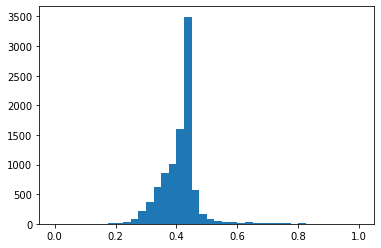

In [18]:
plt.hist(Y_train[:, 0], bins = 40)

(array([1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 1.200e+01, 1.900e+01,
        3.700e+01, 7.000e+01, 1.100e+02, 1.540e+02, 2.010e+02, 2.250e+02,
        3.700e+02, 4.140e+02, 4.410e+02, 4.370e+02, 3.740e+02, 4.010e+02,
        7.460e+02, 5.750e+02, 4.254e+03, 1.110e+02, 3.900e+01, 5.400e+01,
        2.900e+01, 3.100e+01, 3.300e+01, 3.100e+01, 2.200e+01, 3.500e+01,
        2.200e+01, 2.300e+01, 3.000e+01, 1.300e+01, 1.000e+01, 1.000e+01,
        9.000e+00, 3.000e+00, 2.000e+00, 1.000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 40 Patch objects>)

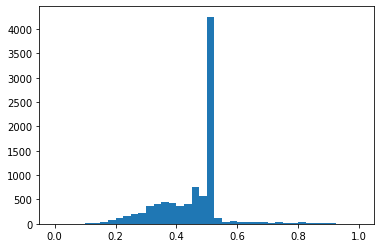

In [19]:
plt.hist(Y_train[:, 1], bins = 40)

(array([  31.,  102.,   95.,   78.,   45.,   34.,   29.,   33.,   22.,
          29.,   19.,   49.,   76.,  103.,  187.,   99.,  124.,  276.,
         608., 4697., 1124.,  323.,  155.,   92.,   90.,   60.,   40.,
          23.,   22.,   27.,   33.,   52.,   37.,   39.,   76.,  119.,
          99.,  131.,   64.,   14.]),
 array([0.00840336, 0.03319328, 0.05798319, 0.08277311, 0.10756303,
        0.13235294, 0.15714286, 0.18193277, 0.20672269, 0.23151261,
        0.25630252, 0.28109244, 0.30588235, 0.33067227, 0.35546218,
        0.3802521 , 0.40504202, 0.42983193, 0.45462185, 0.47941176,
        0.50420168, 0.5289916 , 0.55378151, 0.57857143, 0.60336134,
        0.62815126, 0.65294118, 0.67773109, 0.70252101, 0.72731092,
        0.75210084, 0.77689076, 0.80168067, 0.82647059, 0.8512605 ,
        0.87605042, 0.90084034, 0.92563025, 0.95042017, 0.97521008,
        1.        ]),
 <a list of 40 Patch objects>)

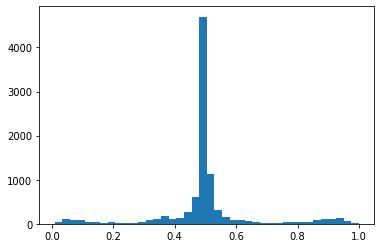

In [20]:
plt.hist(Y_train[:, 2], bins = 40)

In [21]:
np.mean(Y_train, axis = 0)

array([0.4108642 , 0.4588248 , 0.50084878])

In [22]:
np.mean(Y_train * (y_max - y_min) + y_min, axis = 0)

array([-1.86345661e+01, -2.20348440e+03,  1.60602822e+00])

In [23]:
# ts_start and ts_end are integers: minute index
state_dim = [2 * half_x_length + 1, 2 * half_y_length + 1, 2 * half_z_length + 1]
def test_timestep_predictions(ts_start, ts_end):
    X, Y = get_X_Y(flight_data, [i for i in range(0, 11)])
    keys = list(X.keys())
    X = [X[key] for key in keys]
    X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
    Y = [Y[key] for key in keys]
    Y = np.array(Y)
    Y_actual = ((np.array(Y) - y_min)/(y_max - y_min))
    X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
    Y_pred = get_predicted_action(sess, mlp, X)
    Y_pred_transformed = Y_pred * (y_max - y_min) + y_min
    loss = get_loss(sess, mlp, X, Y_actual)
    Y_pred = {keys[i]: Y_pred[i, :] for i in range(len(keys))}
    Y_pred_transformed = {keys[i]: Y_pred_transformed[i, :] for i in range(len(keys))}
    return Y_pred, Y_pred_transformed, loss

Y_pred, Y_pred_transformed, loss = test_timestep_predictions(0, 10)

In [24]:
Y_pred

{(1, '4006AE_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, '71BE28_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A0232A_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A10D82_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A25238_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A30520_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A36F7E_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A64D4D_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A7B832_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A7F6F6_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'A96C96_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'AAFBE3_0'): array([0.4229212 , 0.46909505, 0.49265194], dtype=float32),
 (1, 'AB2B2C_0'): array([0.4229212 , 0.46909505, 0.49265194], dt

In [25]:
def simulate_timestep_predictions(flight_data, ts_start, ts_end):
    for ts in range(ts_start, ts_end + 1):
        X, Y = get_X_Y(flight_data, [ts])
        keys = list(X.keys())
        if len(keys) > 0:
            X = [X[key] for key in keys]
            X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
            Y = [Y[key] for key in keys]
            Y = np.array(Y)
            Y_actual = ((np.array(Y) - y_min)/(y_max - y_min))
            X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
            Y_pred = get_predicted_action(sess, mlp, X)
            Y_pred_transformed = Y_pred * (y_max - y_min) + y_min
            loss = get_loss(sess, mlp, X, Y_actual)
            Y_pred = {keys[i]: Y_pred[i, :] for i in range(len(keys))}
            Y_pred_transformed = {keys[i]: Y_pred_transformed[i, :] for i in range(len(keys))}
            ts_df = flight_data[flight_data['ts'] == ts]
            # if ts == ts_start:
            for key in Y_pred_transformed.keys():
                distance = ts_df[ts_df['id'] == key[1]]['ground_speed'].iloc[0] * 60 * 4.63 / 9 # metres
                lat, lon = destination(ts_df[ts_df['id'] == key[1]]['lat'].iloc[0], ts_df[ts_df['id'] == key[1]]['lon'].iloc[0], ts_df[ts_df['id'] == key[1]]['azimuth'].iloc[0], distance)
                speed = ts_df[ts_df['id'] == key[1]]['ground_speed'].iloc[0] + Y_pred_transformed[key][0]
                altitude = ts_df[ts_df['id'] == key[1]]['altitude'].iloc[0] + Y_pred_transformed[key][1]
                heading = ts_df[ts_df['id'] == key[1]]['azimuth'].iloc[0] + Y_pred_transformed[key][2]

                # Updating values of next time steps
                flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'ground_speed'] = speed
                flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'altitude'] = altitude
                flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'azimuth'] = (heading % (2*math.pi))
                flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'lat'] = lat
                flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'lon'] = lon

            flight_data['x'] = (x_length * (flight_data['lat'] - lat_min - 0.0001)/(lat_max - lat_min)).apply(math.ceil)
            flight_data['y'] = (y_length * (flight_data['lon'] - lon_min - 0.0001)/(lon_max - lon_min)).apply(math.ceil)
            flight_data['z'] = (flight_data['altitude']/alt_bucket_range).apply(math.floor)
            # Dead aircraft: out of x range, y range or z range
            exit_aircraft = flight_data[(flight_data['ts'] == (ts+1)) & ((flight_data['x'] < 0) | (flight_data['x'] >= x_length) | (flight_data['y'] < 0) | (flight_data['y'] >= y_length))]
            crashed = flight_data[(flight_data['ts'] == (ts+1)) & (flight_data['z'] < 0) | (flight_data['z'] >= z_length) | (flight_data['altitude'] < 0) & ((flight_data['lat'] < 40) | (flight_data['lat'] > 41.25) | (flight_data['lon'] < -74.375) | (flight_data['lon'] > -73.125))]
            remove_ids = set(exit_aircraft['id'].tolist() + crashed['id'].tolist())
            flight_data = flight_data[flight_data['id'].apply(lambda x: not(x in remove_ids))]
            print((ts, exit_aircraft.shape[0], crashed.shape[0]))


# else:
#     

In [26]:
simulate_timestep_predictions(flight_data, 0, 25)

(1, 2, 1)


/home/atc/anaconda3/envs/tf/lib/python3.7/site-packages/pandas-0.24.2-py3.7-linux-x86_64.egg/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/atc/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/atc/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

(2, 0, 1)
(3, 4, 0)
(4, 2, 0)
(5, 3, 0)
(6, 2, 1)
(7, 4, 1)
(8, 3, 0)
(9, 5, 0)
(10, 4, 0)
(11, 2, 3)
(12, 6, 0)
(13, 5, 0)
(14, 1, 0)
(15, 3, 0)
(16, 5, 1)
(17, 3, 0)
(18, 6, 1)
(19, 5, 0)
(20, 2, 0)
(21, 2, 1)
(22, 1, 0)
(23, 4, 0)
(24, 4, 2)
(25, 4, 0)
